This Jupyter Notebook is a basic guide to exploratory data analysis using Python Language, SQL Language and SQLite Database, provided by the "Python Fundamentals of Data Analysis 3.0" course offered by the Data Science Academy. Actual publicly available data, movie data on IMDB will be used.
By applying Exploratory Data Analysis it will be possible to answer these 10 questions:

1- What are the Most Common Movie Categories on IMDB?
2- What is the number of titles by genre?
3- What is the Median Rating of Films by Genre?
4- What is the Median Evaluation of Films Regarding the Year of Premiere?
5- What is the number of films evaluated by genre in relation to the year of debut?
6- What is the longest running movie? Calculate the percentiles.
7- What is the relationship between duration and genre?
8- What is the number of films produced per country?
9- What are the Top 10 Best Movies?
10- What are the Top 10 Worst Movies?

In [8]:
from platform import python_version
print('Versão da linguagem python usada neste jupyter notebook', python_version()) 

Versão da linguagem python usada neste jupyter notebook 3.9.7


In [9]:
#instalando o pacote destinado a trazer de forma organizada os dados contidos na plataforma IMDB
!pip install imdb-sqlite

In [10]:
#instalando o pacote que decodifica o padrão ISO as siglas nos nomes dos países
!pip install pycountry 

In [11]:
#Importando pacotes necessários para as análises, visualizaçoes e outros.

#expressão regulares
import re 
#medir tempo de execução ou manipular datas
import time 
#trbalhar com o banco de dados SQLite
import sqlite3 
#decodificar nom de países
import pycountry 
#manipulação de dados
import numpy as np 
#manipulação de dados
import pandas as pd 
#vizualização de dados
import matplotlib.pyplot as plt
#vizualização de dados
import seaborn as sns 
#vizualização de dados
from matplotlib import cm 
#machine learning
from sklearn.feature_extraction.text import CountVectorizer 
#filtrar warnings
import warnings 
warnings.filterwarnings("ignore") 
#define um padrão de fundo branco para os gráficos
sns.set_theme(style = "whitegrid") 

Carregando os dados

In [12]:
%%time
#download dos arquivos com os dados e criar um banco de dados
!imdb-sqlite 

Wall time: 464 ms


2022-03-02 13:58:51,868 DB already exists: (imdb.db). Refusing to modify. Exiting


In [13]:
#conectar ao banco de dados criado através do pacote imdb 
conn = sqlite3.connect("imdb.db")

In [14]:
#extrair a lista de tabelas que estão no banco
tabelas = pd.read_sql_query("SELECT name AS 'Table_Name' FROM sqlite_master WHERE type = 'table'",conn)

In [15]:
#verificar o tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [16]:
#vizualizar os resultados
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [17]:
#convertendo a tabela de nomes e uma lista para facilitar a vizualição
tabelas = tabelas["Table_Name"].values.tolist()

tabelas

['people', 'titles', 'akas', 'crew', 'episodes', 'ratings']

In [18]:
#extrair o schema de cada tabela para conhecer os tipos de dados  e como eles estão organizados

for tabela in tabelas:
    #"PRAGMA TABLE_INFO({})" usado no SQLite extrai as informações da tabela 
    consulta= "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela: ",tabela)
    #display vizualiza o resultado
    display(resultado)
    print("-"*100)
    print("\n")
    

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Análise exploratória dos dados

1 - Quais são as categorias de títulos (filmes) mais comuns no IMDB?

In [ ]:
#Usando uma query SQL é possivel retornar as categorias com mais ocorrências dentro do banco de dados
#GROUP BY permite aplicar funções de agregação, como COUNT(), em grupos, neste exemplo, a query ira realizar a contagem de todos os elementos em cada grupo de categorias

consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type ORDER BY COUNT DESC'''

In [ ]:
#executar a query
resultado1 = pd.read_sql_query(consulta1, conn)

In [ ]:
#vizualizar o resultado
display(resultado1)

,type,COUNT
0,tvEpisode,6529442
1,short,857667
2,movie,603031
3,video,257675
4,tvSeries,221595
5,tvMovie,135112
6,tvMiniSeries,42258
7,tvSpecial,36047
8,videoGame,30513
9,tvShort,10463


In [ ]:
#adicionando uma coluna com o percentual em relação ao total
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) *100

In [ ]:
#vizualizar o resultado
display(resultado1)

,type,COUNT,percentual
0,tvEpisode,6529442,74.846263
1,short,857667,9.831341
2,movie,603031,6.912477
3,video,257675,2.953700
4,tvSeries,221595,2.540119
5,tvMovie,135112,1.548774
6,tvMiniSeries,42258,0.484399
7,tvSpecial,36047,0.413203
8,videoGame,30513,0.349767
9,tvShort,10463,0.119936


In [ ]:
#Consolidando um pouco mais, seria possivel condençar a tabela em apenas 4 categorias, as 3 maiores e as demais em "outros"
#Para isso, um dicionário poderia armazenar a nova categoria, inicialmente, devido ao seu carater de chave-valor

others = {}

#filtra o percentual que esta abaixo de 5% e soma o total destes
others['COUNT'] = resultado1[resultado1['percentual']<5]['COUNT'].sum()

#gravando o percentual
others['percentual'] = resultado1[resultado1['percentual']<5]['percentual'].sum()

#ajusta o nome na tabela 
others['type']= 'others'



In [ ]:
#vizualizando o resultado
others

{'COUNT': 733665, 'percentual': 8.409919754052275, 'type': 'others'}

In [ ]:
#filtra o dataframe com as categorias com mais de 5% de ocorrencias para montar o resultado 
resultado1 = resultado1[resultado1['percentual']>5]

In [ ]:
#append com o dataframe "others"
resultado1 = resultado1.append(others, ignore_index= True)

In [ ]:
#testando
display(resultado1)

,type,COUNT,percentual
0,tvEpisode,6529442,74.846263
1,short,857667,9.831341
2,movie,603031,6.912477
3,others,733665,8.409920


In [ ]:
#ordenando a partir do numero de ocorrências "COUNT"
resultado1 = resultado1.sort_values(by = 'COUNT', ascending= False)

In [ ]:
#visualizando
resultado1.head()

,type,COUNT,percentual
0,tvEpisode,6529442,74.846263
1,short,857667,9.831341
3,others,733665,8.409920
2,movie,603031,6.912477


In [ ]:
#para tornar a visualização ainda mais eficiente, criar um gráfico pode ser uma boa opção
#ajustando as labels
#abaixo temos o uso de uma list comprehension, que consiste em usar um loop e suas instruções dentro de um unico comando, leia-se do final para o inicio: para cada item em "resultado1", transforme em string o seu respectivo "type", concatene com um espaco em branco, junto do percentual arredondado em duas casas
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2))+'%'+']' for i in resultado1.index]



<function matplotlib.pyplot.show(close=None, block=None)>

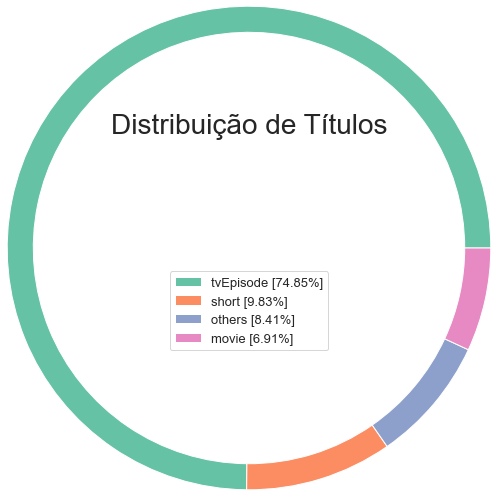

In [ ]:
#montando o gráfico
#selecionando o mapa de cores
cs = cm.Set2(np.arange(100))

#plt.figure é responsavel por tornar acessivel as metricas da figura (entenda figura como o espaço de visualização, uma "janela" que será configurada para mostrar "plt.show"), editar parametros originais
f = plt.figure

#configurando o grafico de pizza
#plt.pie seleciona o modelo de grafico de pizza, tendo como primeiro parametro qual serao os dados a serem representados, após, "labeldistance", que eu ainda nao descobri o que é, "radius" seria o tamanho em rad da circunferência, "colors", obviamente, esquema de cores a serem utilizados, "wedgeprops", proporção das paredes de cada fatia, em "none", temso um grafico com as paredes totalmentes unidas no centro, com dict(width = x) teremos a distancia x do centro, formando um grafico rosca
plt.pie(resultado1['COUNT'], labeldistance= 1, radius= 2.78, colors= cs, wedgeprops= dict(width = 0.3))
#plt.legend aplica as legendas de forma separada ao grafico em si (ou seja, permite maior customização por estar em outro parametro). "labels" seria o titulo de cada fatia, neste caso, os types com suas porcentagens, "loc", localização da legenda na no grafico, "prop", edita os parametrso de tamanho da legenda
plt.legend(labels = labels, loc = 'lower center', prop = {'size':13})
#plt.title permite editar parametros do titulo do grafico, primeiro valor temso o titulo, "loc", mais uma vez se refere a localização da string, "fontdict" edita metricas da string, como peso e tamanho
plt.title("Distribuição de Títulos", loc = 'center', fontdict={'fontsize' : 28, 'fontweight':20})
#plt.show apresenta o grafico sem retornos do matplotlib, como os parametros internos
plt.show
